### Lab 2: Neural Machine Translation improvement with Self-Critical Sequence Training

In this extra task we will try to get higher score using SCST approach.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/colab/NLP_LAB2/

/content/drive/MyDrive/colab/NLP_LAB2


In [3]:
%%capture

# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

!pip install torchtext
!pip install nltk

In [4]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_to_data = './data.txt'

if not os.path.exists(path_to_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_to_data = './data.txt'

In [5]:
import math
import time
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchtext
from torchtext.legacy.data import Field, BucketIterator, TabularDataset
from torchtext.data.metrics import bleu_score

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from tqdm.notebook import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline
sns.set_style("dark")
from IPython.display import clear_output

In [6]:
SEED = 777

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Load models and utils from own modules

In [ ]:
# %load_ext autoreload
# %autoreload 1
# %aimport utils

In [8]:
from utils import *
from models import *

### Preprocessing

In [9]:
wp_tokenizer = WordPunctTokenizer()

SRC = Field(
    tokenize=lambda x: wp_tokenizer.tokenize(x.lower()),
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True,
)

TRG = Field(
    tokenize=lambda x: wp_tokenizer.tokenize(x.lower()),
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True,
)

In [10]:
BATCH_SIZE = 128

(SRC, TRG), (train_data, valid_data, test_data), (train_iterator, valid_iterator, test_iterator) = prepare_iterators(SRC, TRG, BATCH_SIZE, device, path_to_data)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500

Unique tokens in source (ru) vocabulary: 9289
Unique tokens in target (en) vocabulary: 6746


Here are few tokens from original (RU) corpus and from target (EN) corpus:

In [11]:
SRC.vocab.itos[::1000], TRG.vocab.itos[::1000]

(['<unk>',
  'home',
  'шезлонгах',
  'зеленых',
  'chiado',
  '86',
  'lion',
  'финансового',
  'детское',
  'сычуаньской'],
 ['<unk>', 'perfect', 'desks', 'classics', 'nikola', 'scandic', 'm3'])

And here is example from train dataset:

In [12]:
example = vars(train_data.examples[17])
print(f"SRC: {example['src']}\nTRG: {example['trg']}")

SRC: ['номера', 'оснащены', 'телевизором', ',', 'а', 'в', 'некоторых', 'есть', 'кондиционер', '.', 'в', 'распоряжении', 'гостей', 'общая', 'ванная', 'комната', '.']
TRG: ['rooms', 'include', 'a', 'tv', '.', 'each', 'room', 'has', 'a', 'shared', 'bathroom', 'and', 'some', 'are', 'air', 'conditioned', '.']


Let's check the length distributions:

Length distribution in Train data


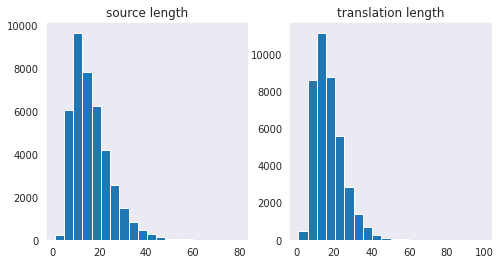

In [13]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
show_length_distributions(src_length, trg_length)

Length distribution in Test data


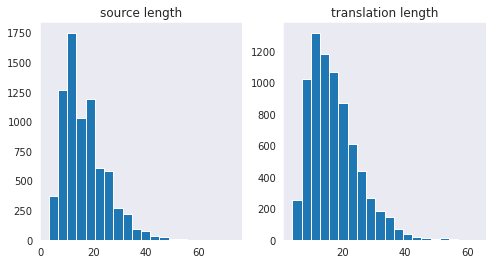

In [14]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
show_length_distributions(src_length, trg_length)

### Base model (LSTM->LSTM)

As a baseline model I have taken simple RNN architecture. 

P.S. Unfortunately, there was a large number of poor attempts to fit Transformer NMT model, but I often exceeded memory limits, also inference of Transformer model was pretty slow. Lowering of batch size helped to pass memory problems, but BLEU score usually decreased.

Luckily, LSTM model helped to achieve slight improvement :)

In [21]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.4
DEC_DROPOUT = 0.4

# define model
enc = LSTMEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = LSTMDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = LSTMSeq2Seq(enc, dec, device).to(device)

model.apply(initialize_weights);
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,922,074 trainable parameters


In [22]:
PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1.

best_valid_loss = float('inf')

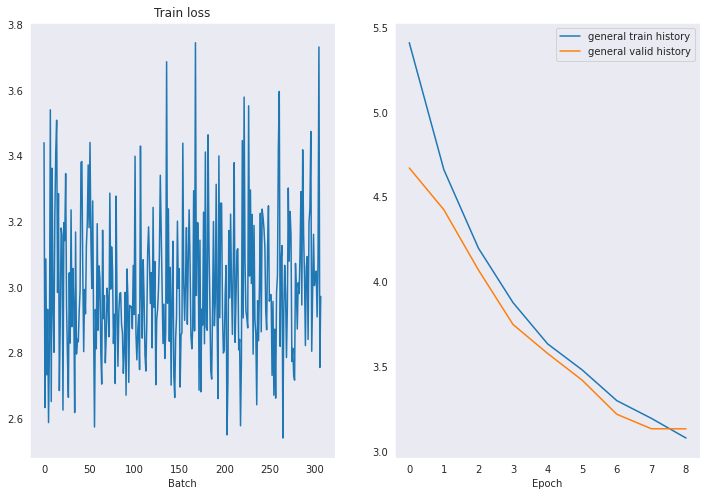

Epoch: 10 | Time: 1m 59s
	Train Loss: 3.003 | Train PPL:  20.147
	 Val. Loss: 3.015 |  Val. PPL:  20.381
Total time: 19m 57s


In [23]:
start_time = time.time()
for epoch in range(N_EPOCHS):
    
    epoch_start_time = time.time()
    
    train_loss = train_epoch(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_epoch(model, valid_iterator, criterion)
    epoch_end_time = time.time()
    
    epoch_mins, epoch_secs = report_time(epoch_start_time, epoch_end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'checkpoint_nmt_pre_scst_lstm.pth')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    if epoch + 1 == N_EPOCHS:
        total_mins, total_secs = report_time(start_time, epoch_end_time)
        print(f'Total time: {total_mins}m {total_secs}s')

Evaluate

In [24]:
# lstm
batch = next(iter(test_iterator))
orig, gen = generate_batch_translation(batch.src[:, 10:20], batch.trg[:, 10:20], model, TRG)

Original: room service is also available .
Generated: room is also available .

Original: extras include ironing facilities .
Generated: the property offers a washing machine .

Original: free private parking is available on site .
Generated: free private parking is available on site .

Original: guests can enjoy a meal at the on - site restaurant .
Generated: guests can enjoy the on - site restaurant .

Original: free wi - fi access is available .
Generated: free wifi access is available .

Original: rooms are equipped with a tv .
Generated: all rooms include a tv .

Original: some rooms offer a balcony .
Generated: some rooms include a balcony .

Original: it also includes an outdoor pool .
Generated: a terrace and a terrace .

Original: free wifi access is available .
Generated: free wifi access is available .

Original: the unit is fitted with a kitchen .
Generated: the kitchen is equipped with a .



In [25]:
# base score lstm
bleu= calculate_bleu(model, test_iterator, TRG)
print(f'BLEU score = {bleu * 100:.3f}')


BLEU score = 13.305


### Self-Critical Sequence Training (SCST)

Now we begin SCST part.

Below is the function for translation with `greedy` flag.

In [28]:
# lstm
TRG_INIT_IDX = TRG.vocab.stoi[TRG.init_token]
TRG_EOS_IDX = TRG.vocab.stoi[TRG.eos_token]

def translate(model, src, trg_init_idx=TRG_INIT_IDX, trg_eos_idx=TRG_EOS_IDX, max_len=100, greedy=True, eps=1e-15):
    # src = [bs, src_len]
    bs = src.shape[0]
    trg_vocab_size = model.decoder.output_dim

    #encoder_outputs is all hidden states of the input sequence, back and forwards
    #hidden is the final forward and backward hidden states, passed through a linear layer
    hidden, cell = model.encoder(src.permute(1, 0))

    generated = torch.LongTensor([trg_init_idx]).repeat(bs, 1).to(model.device)
    gen_t = torch.LongTensor([trg_init_idx]).repeat(bs).to(model.device)
    logits_seq = [torch.log(to_one_hot(generated[:,0], trg_vocab_size) + eps)]
    mask = torch.ones(bs, dtype=torch.uint8).to(model.device)

    for t in range(1, max_len):
        #insert input token embedding, previous hidden state and all encoder hidden states
        #receive output tensor (predictions) and new hidden state
        logits, hidden, cell = model.decoder(gen_t, hidden, cell)
        # logits = [bs, output_dim]
        if greedy:
            gen_t = logits.argmax(dim=1)
        else:
            probs = F.softmax(logits, dim=1)
            gen_t = torch.multinomial(probs, 1)[:, 0]

        generated = torch.hstack([generated, gen_t.unsqueeze(1)])
        # gen_tensor = [bs, t+1]

        logits_seq.append(logits)

        mask *= gen_t != trg_eos_idx
        if not mask.any(): 
            break

    # generated = [bs, <=max_len], log_probs = [bs, <=max_len, output_dim]
    return generated, F.log_softmax(torch.stack(logits_seq, 1), dim=-1)

Reward for SCST procedure is BLEU - the metric we want to maximize.

**Note**: there is significant difference between `torchtext.data.metrics.bleu_score` and `nltk.translate.bleu_score.corpus_bleu`. We use second one for our final evaluation, however, it ignores order of words in the sentence, while the first one does not. Thus, `torchtext.data.metrics.bleu_score` is a more strict metric. I decided to use this first variant in reward calculation, so the model would not be very stochastic (previous launches with `nltk.translate.bleu_score.corpus_bleu` led to decrease of BLEU on validation). Also, the LSTM model is not perfect enough to get BLEU-4 score greater than zero on most part of data. Finally, the reward was calculated as average score of independent BLEU-2, BLEU-3 and BLEU-4 that are aware of token order.

In [26]:
def compute_reward(trg, translations, trg_vocab):
    """ computes sample-wise reward given token ids for inputs and translations """
    # trg = [bs, trg_len]
    # translations = [bs, max_len]
    original_text = [get_text(orig.tolist(), trg_vocab) for orig in trg]
    generated_text = [get_text(gen.tolist(), trg_vocab) for gen in translations]

    # calculate reward as mean of independent BLEU scores of order 2, 3, and 4 
    reward = 0
    for N in range(2, 4+1):
        bleu_n = bleu_score(generated_text, [[orig] for orig in original_text], max_n=N, weights=(1/N,)*N)
        reward += 1/3 * bleu_n

    # reward = corpus_bleu([[orig] for orig in original_text], generated_text)
    # for orig, gen in zip(original_text, generated_text):
    #     print('Original: {}'.format(' '.join(orig)))
    #     print('Generated: {}'.format(' '.join(gen)))
    # print(f'BLEU: {reward}')

    return torch.tensor([reward])


def scst_objective_on_batch(model, src, trg, trg_field, reg_coef=0.01):
    """ Compute pseudo-loss for policy gradient given a batch of sources """
    # src = [bs, src_len]
    # trg = [bs, trg_len]

    # make sample and greedy translation for input src

    # sample_translations, sample_logp = model.translate(src, greedy=False)
    # greedy_translations, greedy_logp = model.translate(input_sequence, greedy=True)

    sample_translations, sample_logp = translate(model, src, greedy=False)
    greedy_translations, greedy_logp = translate(model, src, greedy=True)
    # sample_translations = greedy_translations = [bs, max_len]
    # sample_logp = greedy_logp = [bs, max_len, output_dim]

    # compute rewards and advantage
    # be careful with the device, rewards require casting to numpy, so send everything to cpu
    rewards = compute_reward(trg.cpu(), sample_translations.cpu(), trg_field.vocab)
    baseline = compute_reward(trg.cpu(), greedy_translations.cpu(), trg_field.vocab)

    # compute advantage using rewards and baseline
    # be careful with the device, advantage is used to compute gradients, so send it to device
    advantage = (rewards - baseline).float().to(model.device)

    # compute log_pi(a_t|s_t), shape = [batch, seq_length]
    logp_sample = torch.sum(to_one_hot(sample_translations, n_dims=len(trg_field.vocab)) * sample_logp, dim=-1)

    # policy gradient pseudo-loss. Gradient of J is exactly policy gradient.
    J = logp_sample * advantage[:, None]

    assert J.dim() == 2, "please return elementwise objective, don't compute mean just yet"

    # average with mask
    mask = infer_mask(sample_translations, trg_field.vocab.stoi[trg_field.eos_token])
    loss = - torch.sum(J * mask) / torch.sum(mask)

    # regularize with negative entropy. Don't forget the sign!
    # note: for entropy you need probabilities for all tokens (sample_logp), not just logp_sample
    entropy = -torch.sum(torch.exp(sample_logp) * sample_logp, dim=-1)
    # <compute entropy matrix of shape[batch, seq_length], H = -sum(p*log_p), don't forget the sign!>
    # hint: you can get sample probabilities from sample_logp using math :)

    assert entropy.dim() == 2, "please make sure elementwise entropy is of shape [batch,time]"

    reg = - reg_coef * torch.sum(entropy * mask) / torch.sum(mask)

    return loss + reg, torch.sum(entropy * mask) / torch.sum(mask)

Function for SCST iteration. Few comments on arguments:

- scst_batch_size - lower (or equal) batch size for SCST training. It was important for Transformer model, because it exceeded memory limits. For LSTM model this batch size was equal to initial batch size

- n_train_batches - number of small batches from initial batch for Transfomer model. Not used for LSTM model.

In [27]:
def scst_iteration(model, scst_batch_size, TRG, train_iterator, valid_iterator, optimizer, n_epochs=1, clip=1, n_train_batches=5):

    model.train()
    output_dim = model.decoder.output_dim
    epoch_loss = 0
    loss_history = []
    bleu_history = []
    entropy_history = []

    for epoch in range(n_epochs):
        for i, batch in enumerate(train_iterator):
            model.train()

            # ----- THIS WAS USED FOR TRANSFORMER MODEL INFERENCE -----
            # loss, ent = 0, 0
            # ids = torch.randperm(len(batch))[:scst_batch_size * n_train_batches]
            # for start_ix in range(0, scst_batch_size * n_train_batches, scst_batch_size):
            #     ids_ = ids[start_ix : start_ix + scst_batch_size]
            #     src = batch.src.permute(1, 0)[ids_]
            #     trg = batch.trg.permute(1, 0)[ids_]
            #     loss_, ent_ = scst_objective_on_batch(model, src, trg, TRG)
            #     loss += loss_
            #     ent += ent_
            #     gc.collect()

            #
            ids = torch.randperm(len(batch))[:scst_batch_size]
            src = batch.src.permute(1, 0)[ids]
            trg = batch.trg.permute(1, 0)[ids]

            loss, ent = scst_objective_on_batch(model, src, trg, TRG)
            #

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss
            
            loss_history.append(loss)
            entropy_history.append(ent)

            if (i + 1)%(20) == 0:
                clear_output(True)

                model.eval()
                val_bleu = calculate_bleu(model, valid_iterator, TRG, verbose=False)
                # gc.collect()
                bleu_history.append(val_bleu)

                # print few original/generated examples
                val_batch = next(iter(valid_iterator))
                ids = torch.randperm(len(batch))[:3]
                src = batch.src[:, ids]
                trg = batch.trg[:, ids]
                print("Validation:")
                generate_batch_translation(src, trg, model, TRG)

                fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 7))

                ax[0].plot(loss_history, label='train loss')
                ax[0].set_xlabel('Batch')
                ax[0].set_title(f'Train loss | Epoch {epoch+1}/{n_epochs}')
                ax[1].plot(entropy_history, label='train entropy')
                ax[1].set_xlabel('Batch')
                ax[1].set_title(f'Train entropy | Epoch {epoch+1}/{n_epochs}')
                ax[2].plot(bleu_history, label='val BLEU')
                ax[2].set_xlabel('Batch')
                ax[2].set_title(f'Val BLEU | Epoch {epoch+1}/{n_epochs}')
                plt.legend()
                plt.show()

    return loss_history, entropy_history, bleu_history

In [ ]:
# model.load_state_dict(torch.load("checkpoint_nmt_pre_scst_lstm.pth", map_location=device))

<All keys matched successfully>

Train 1 epoch


Validation:
Original: located within a 15 - minute drive from golden beach and the heritage centre , residency operates a 24 - hour front desk to welcome and assist guests . free wifi access is available throughout the property .
Generated: just a minutes - minute drive from beach , , inn & b offers free wi - fi and a 24 - hour front desk and a restaurant and a restaurant .

Original: there is a shared lounge at the property .
Generated: you will find a shared kitchen at the property .

Original: all rooms have a flat - screen tv .
Generated: every room is fitted with a flat - screen tv .



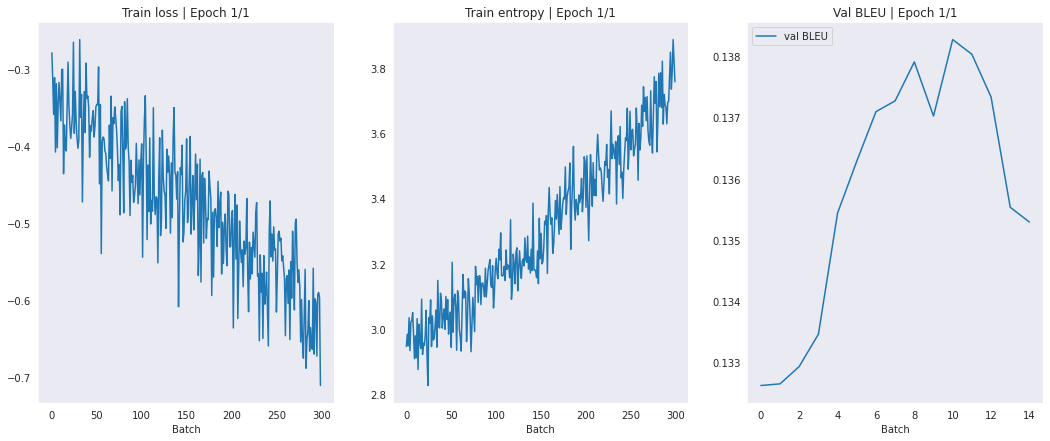

CPU times: user 3min 53s, sys: 2.25 s, total: 3min 55s
Wall time: 3min 56s


In [29]:
%%time
# lstm
SCST_BATCH_SIZE = 128
N_EPOCHS = 1
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scst_iteration(model, SCST_BATCH_SIZE, TRG, train_iterator, valid_iterator, optimizer, n_epochs=N_EPOCHS, clip=1.)

In [30]:
# scst lstm 1 epoch
bleu = calculate_bleu(model, test_iterator, TRG)
print(f'BLEU score = {bleu * 100:.3f}')


BLEU score = 13.902


Wow! BLEU score became larger!

In [31]:
# torch.save(model.state_dict(), 'checkpoint_nmt_scst_lstm_1.pth')

In [32]:
# model.load_state_dict(torch.load("checkpoint_nmt_pre_scst_lstm.pth", map_location=device))

<All keys matched successfully>

Try again on 3 SCST epochs


Validation:
Original: lindos is at a distance of 4 km , while a variety of water sport facilities can be found within 3 km .
Generated: the of is 1 km away , while the can be found within the km .

Original: casa corte is located 6 km from and 5 km from la beach .
Generated: inn & b is is km from from the centre of , while km from the .

Original: 200 metres from shopping centre mangga dua , best western mangga dua hotel and residence features modern air - conditioned rooms .
Generated: located just a metres from the beach of , hotel offers rooms with free wi - fi .



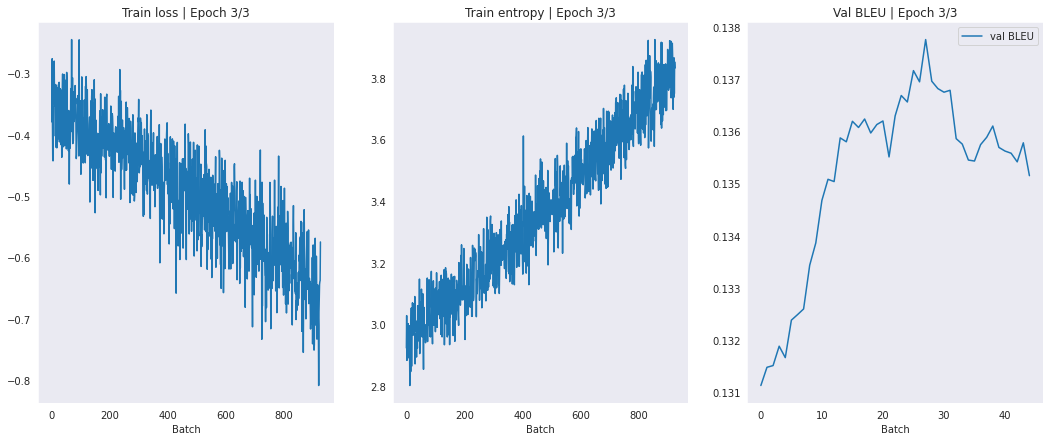

CPU times: user 11min 45s, sys: 6.43 s, total: 11min 52s
Wall time: 11min 54s


In [33]:
%%time
# lstm
SCST_BATCH_SIZE = 128
N_EPOCHS = 3
optimizer = optim.Adam(model.parameters(), lr=3e-6)
scst_iteration(model, SCST_BATCH_SIZE, TRG, train_iterator, valid_iterator, optimizer, n_epochs=N_EPOCHS, clip=1.)

Watch on few translation examples and evaluate

In [35]:
batch = next(iter(test_iterator))
orig, gen = generate_batch_translation(batch.src[:, 10:20], batch.trg[:, 10:20], model, TRG)

Original: room service is also available .
Generated: room room service .

Original: extras include ironing facilities .
Generated: the property also offers luggage storage .

Original: free private parking is available on site .
Generated: free private parking is available on site .

Original: guests can enjoy a meal at the on - site restaurant .
Generated: guests can enjoy the on - site restaurant .

Original: free wi - fi access is available .
Generated: free wifi access is available .

Original: rooms are equipped with a tv .
Generated: all rooms include a tv .

Original: some rooms offer a balcony .
Generated: some rooms include a balcony .

Original: it also includes an outdoor pool .
Generated: guests can enjoy a meal at the on - site bar .

Original: free wifi access is available .
Generated: free wifi access is available .

Original: the unit is fitted with a kitchen .
Generated: the kitchen is equipped with a washing machine .



In [34]:
# scst lstm 3 epochs
bleu = calculate_bleu(model, test_iterator, TRG)
print(f'BLEU score = {bleu * 100:.3f}')


BLEU score = 13.932


Even better :)

Total improvement in BLEU ~ 0.6

In [36]:
# torch.save(model.state_dict(), 'checkpoint_nmt_scst_lstm_3.pth')

**To sum up:**

SCST is powerful method to tune non-differentiable metric, although it needs very accurate choice of parameters (learning rate, batch size, regularization coefficient for entropy, ...)